In [1]:
from dimod import ConstrainedQuadraticModel, Integer
from dwave.system import LeapHybridCQMSampler
import easydict
import kqc_custom
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
args = easydict.EasyDict()
# my_api_token = TOKEN
my_api_token = "DEV-8be99a69b1c9b92319d76a12d5c8b4fde79963b4"
args['token'] = "DEV-8be99a69b1c9b92319d76a12d5c8b4fde79963b4"
sampler = LeapHybridCQMSampler(token = args['token'])

In [3]:
def projection(X):
    xtx = np.matmul(X.T,X)
    xtxinv = np.linalg.inv(xtx)
    proj = np.matmul(np.matmul(X,xtxinv),X.T)
    return(proj)

def partial_r1(X,y):
    X = np.asarray(X);y=np.asarray(y).reshape((-1))
    n = X.shape[0]
    X_temp = pd.DataFrame(np.ones((n,1))); X = pd.DataFrame(X)
    X_temp = np.asarray(pd.concat([X_temp,X],axis=1))
    q=X_temp.shape[1]
    y = y-np.mean(y)
    partial_r_list = []
    SSRF = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp))),y)
    for i in range(1,q):
        ind = [i for i in range(i)] + [i for i in range(i+1,q)]
        SSRR = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp[:,ind]))),y)
        partial_r_list += [1-SSRF/SSRR]
    return(np.array(partial_r_list))
def partial_r2(X,y):
    n = X.shape[0]
    X_temp = pd.DataFrame(np.ones((n,1))); X = pd.DataFrame(X)
    X_temp = np.asarray(pd.concat([X_temp,X],axis=1)) ; y = np.asarray(y)
    p=X_temp.shape[1]
    y = y-np.mean(y)
    partial_r_list = []
    SSRF = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp))),y)
    for i in range(1,p):
        SSRR = np.matmul(np.matmul(y.T,(np.identity(n)-projection(X_temp[:,[0,i]]))),y)
        partial_r_list += [SSRF/SSRR]
        
def mse(X,y):
    q = X.shape[0]
    xtx = np.matmul(X.T,X)
    xtxinv = np.linalg.inv(xtx)
    proj = np.matmul(np.matmul(X,xtxinv),X.T)
    mse = np.matmul(np.matmul(y.T,(np.identity(q)-proj)),y)/q
    return(mse)

def cn(X): 
    if X.shape[1]==1 : return(1)
    cordata = np.corrcoef(X.T)
    eig_value = np.linalg.eig(cordata)[0]
    return(np.max(eig_value)/np.min(eig_value))

In [4]:
# 함수화
# 결과물 : Full, True, Dwave boxplot 의 mse 비교, aic 비교, cn 비교
# 1. dwave 함수
def dwave(x,y):
    data_x = pd.DataFrame(x)
    data_y = pd.DataFrame(y)
    p = data_x.shape[1]
    Q = np.abs(data_x.corr())
    beta = -Q.apply(sum)
    for i in range(p) : 
        Q.iloc[i,i] = 0 
        r_squared_list = []
        names = []
        for i in range( len(data_x.columns )) :
            names.append("x"+str(i))
        data_x.columns = names    
            
    beta2 = -Q.apply(sum)
    beta2_with_r2 = beta2 - partial_r1(x,y)
    B=beta2_with_r2
    integer_list = []
    for i in range(10):
        integer_list.append(Integer(str("x")+str("0")+str("0")+str(i), upper_bound=1,lower_bound=0))
    for i in range(10,100) :
        integer_list.append(Integer(str("x")+str("0")+str(i), upper_bound=1,lower_bound=0))
    for i in range(100,p) :
        integer_list.append(Integer(str("x")+str(i), upper_bound=1,lower_bound=0))
        
    linear_qubo = B[0]*integer_list[0]*0
    for i in range(p): 
        linear_qubo = linear_qubo + B[i]*integer_list[i]
    
    quadratic_qubo = Q[0][0]*integer_list[0]*integer_list[0]*0
    for j in range(p):
        for i in range(p):
            quadratic_qubo= quadratic_qubo+Q[i][j]*integer_list[i]*integer_list[j]
    
    Qubo = linear_qubo + quadratic_qubo
    cqm= ConstrainedQuadraticModel()
    cqm.set_objective(Qubo)
    sampleset = sampler.sample_cqm(cqm)
    
    result = sampleset.first[0]
    result_list=list(zip(result.keys(), result.values()))
    
    data_x_result=pd.DataFrame(result_list).T.loc[[1]]
    names = []
    for i in range( len(data_x_result.columns )) :
        names.append("x"+str(i))
    data_x_result.columns = names  
    data_y.columns = ["y"]
    
    data_x_result.index = ["Selection"]
    data_x_result=pd.to_numeric(data_x_result.T["Selection"])
    
    concat_x = pd.concat([pd.DataFrame(data_x_result).T, data_x], axis = 0)
    concat_x_one=concat_x.T[concat_x.T["Selection"]==1].T
    data_x_one =concat_x_one.loc[0:,:]
    
    
    mse_result=mse( np.array(data_x_one) ,np.array(data_y))
    aic_result = (len(data_x_one)* np.log(mse_result) - 10 *np.log(len(data_x_one)) + 2* len(data_x_one.columns))
    cn_result = cn(data_x_one)
    return result, mse_result, aic_result, cn_result

In [5]:
def full(x,y):
    data_x = pd.DataFrame(x)
    data_y = pd.DataFrame(y)
    mse_result=mse( np.array(data_x) ,np.array(data_y))
    aic_result = (len(data_x)* np.log(mse_result) - 10 *np.log(len(data_x)) + 2* len(data_x.columns))
    cn_result = cn(data_x)
    
    return mse_result, aic_result, cn_result

In [14]:
def random(x,y):
    # 랜덤 추출

    data_x = pd.DataFrame(x)
    data_y = pd.DataFrame(y)
    p = data_x.shape[1]
    random_list=pd.DataFrame(np.random.binomial(n=1, p=0.5, size=p)).T
    random_list.index = ["Selection"]
    data_x=pd.concat([random_list,data_x])
    
    names = []
    for i in range( len(data_x.columns )) :
        names.append("x"+str(i))
    data_x.columns = names  
    data_y.columns = ["y"]
    
    data_x_one= data_x.T[data_x.T["Selection"]==1].T[1:]
    mse_result=mse( np.array(data_x_one) ,np.array(data_y))
    aic_result = (len(data_x_one)* np.log(mse_result) - 10 *np.log(len(data_x_one)) + 2* len(data_x_one.columns))
    cn_result = cn(data_x_one)    
    return mse_result, aic_result, cn_result

In [398]:
#### Data 1 
x1,y1 = kqc_custom.generate_dependent_sample(500,200,beta_coef=[5,5,5,5,5,5,5,5,5,5],epsilon = 10,covariance_parameter=100)

In [399]:
cn(x1)

296824.77280980686

In [ ]:
cn(x1[:,:100])

In [405]:
data_x_1=pd.DataFrame(x1)
data_y_1=pd.DataFrame(y1)
data_x_1.to_excel('data_x1.xlsx')
data_y_1.to_excel('data_y1.xlsx')
pd.DataFrame(full_1).to_excel('data_x1_full.xlsx')
pd.DataFrame(true_1).to_excel('data_x1_true.xlsx')
pd.DataFrame(random_1).to_excel('data_x1_random.xlsx')
pd.DataFrame(dwave_1).to_excel('data_x1_dwave.xlsx')

C:\Users\user\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


PermissionError: [Errno 13] Permission denied: 'data_x1_dwave.xlsx'

In [82]:
# Real Variables
full_1 = full(x1,y1)
full_1

(array([[0.15844291]]), array([[-583.32654679]]), 3066.1169297047854)

In [294]:
sfnsdkfnsfnsdfksflnslkf

C:\Users\user\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [83]:
# True Variables
true_1 = full(pd.DataFrame(x1).iloc[:,[0,1,2,3,4,5,6,7,8,9]],y1)
true_1

(array([[0.2531464]]), array([[-729.03972958]]), 2.1642845072259007)

In [84]:
# Random Variables

random_1=[]
for i in range(10):
    random_1.append(random(x1,y1))
random_1

[(array([[2331.24115012]]), array([[4002.93196261]]), 52.86610788821716),
 (array([[2309.95437019]]), array([[4012.34544409]]), 49.595596230594765),
 (array([[2037.5038368]]), array([[3943.59428312]]), 51.278137617504285),
 (array([[1007.86940149]]), array([[3581.65085813]]), 32.798300183516766),
 (array([[2451.65391897]]), array([[4034.11299139]]), 46.238490896036545),
 (array([[1009.01012297]]), array([[3610.2164455]]), 62.41988905646636),
 (array([[823.4954989]]), array([[3484.63296091]]), 38.57179723793542),
 (array([[2618.25257908]]), array([[4062.98512886]]), 42.047007319491385),
 (array([[1290.31947437]]), array([[3697.17647964]]), 31.929117900003394),
 (array([[1883.20769331]]), array([[3900.21982988]]), 46.31250514523144)]

In [219]:
mse_r_1 = pd.DataFrame(random_1).iloc[:,[0]].astype(np.float)
aic_r_1 = pd.DataFrame(random_1).iloc[:,[1]].astype(np.float)
cn_r_1 = pd.DataFrame(random_1).iloc[:,[2]].astype(np.float)

C:\Users\user\AppData\Local\Temp/ipykernel_18440/2860171053.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_1 = pd.DataFrame(random_1).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/2860171053.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aic_r_1 = pd.DataFrame(random_1).iloc[:,[1]].astype(np

In [85]:
# Dwave Selected

dwave_1=[]
for i in range(10):
    dwave_1.append(dwave(x1,y1))

In [86]:
pd.DataFrame(dwave_1)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20222110827722029]],[[-661.3428733751858]],38.784755
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20298601431267094]],[[-655.4551796468186]],41.255625
2,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[254.1132438447187]],[[2908.7439238002307]],39.638611
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20571577984840309]],[[-650.7759671551325]],39.225963
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2077732729948928]],[[-647.7999947232214]],44.078657
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[265.4484239352847]],[[2930.564199855926]],46.370009
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[269.79372213991405]],[[2938.6827564824325]],41.287250
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[275.0546676222079]],[[2944.338853647614]],38.889288
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20485951337042377]],[[-650.8614986850331]],40.119000
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[265.79274870851765]],[[2929.2123514661193]],42.254662


In [152]:
mse_1 = pd.DataFrame(dwave_1).iloc[:,[1]].astype(np.float)
aic_1 = pd.DataFrame(dwave_1).iloc[:,[2]].astype(np.float)
cn_1 = pd.DataFrame(dwave_1).iloc[:,[3]].astype(np.float)

C:\Users\user\AppData\Local\Temp/ipykernel_18440/2946347843.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_1 = pd.DataFrame(dwave_1).iloc[:,[1]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/2946347843.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aic_1 = pd.DataFrame(dwave_1).iloc[:,[1]].astype(np.float

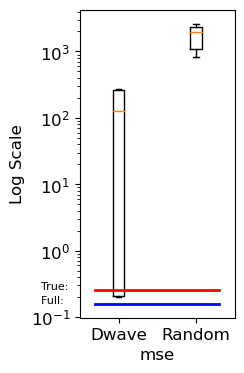

In [269]:
# Data 1 mse

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(mse_1.T.append(mse_r_1.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('mse')
ax.set_ylabel('Log Scale')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_1[0], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_1[0]),f'Full:  ',fontsize=8)
plt.axhline(true_1[0], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_1[0]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)
plt.show()

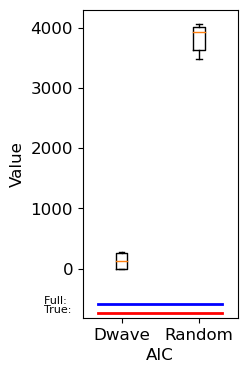

In [275]:
# Data 1  AIC

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(aic_1.T.append(aic_r_1.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('AIC')
ax.set_ylabel('Value')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_1[1], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_1[1]),f'Full:  ',fontsize=8)
plt.axhline(true_1[1], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_1[1]),f'True:  ',fontsize=8)
# plt.yscale('log', base=10)
plt.show()

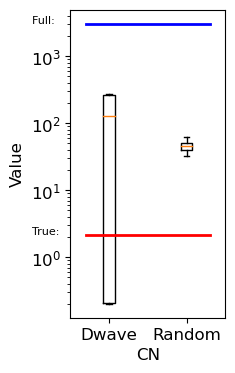

In [281]:
# Data 1  CN

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(cn_1.T.append(cn_r_1.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('CN')
ax.set_ylabel('Value')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_1[2], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_1[2]),f'Full:  ',fontsize=8)
plt.axhline(true_1[2], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_1[2]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)
plt.show()

In [361]:
import seaborn as sns
sns.set_theme()

In [87]:
#### Data 2
x2,y2 = kqc_custom.generate_dependent_sample(1000,200,beta_coef=[10,10,10,10,10,10,10,10,10,10],epsilon = 0.5)

In [88]:
# Real Variables
full_2 = full(x2,y2)
full_2

(array([[0.1781473]]), array([[-1394.22208001]]), 1895.878288335867)

In [89]:
# True Variables
true_2 = full(pd.DataFrame(x2).iloc[:,[0,1,2,3,4,5,6,7,8,9]],y2)
true_2

(array([[0.22812875]]), array([[-1526.92268706]]), 2.2668378275881365)

In [90]:
# Random Variables

random_2=[]
for i in range(10):
    random_2.append(random(x2,y2))
random_2

[(array([[9772.32368973]]), array([[9324.23200324]]), 36.622606319102324),
 (array([[11688.71919556]]), array([[9495.30193156]]), 31.546824026584037),
 (array([[4388.79199625]]), array([[8501.73174372]]), 27.621766450329893),
 (array([[16294.79059183]]), array([[9801.52318733]]), 23.948084728615505),
 (array([[6928.36316201]]), array([[8978.30131554]]), 39.73369419948681),
 (array([[3639.49333777]]), array([[8338.52220523]]), 50.325279686664715),
 (array([[7249.16440059]]), array([[9031.56393333]]), 46.43150679730744),
 (array([[3827.51069139]]), array([[8392.89236805]]), 52.46003654390028),
 (array([[6520.14001642]]), array([[8905.57357681]]), 30.712255105384713),
 (array([[7378.09559555]]), array([[9025.19328212]]), 32.664266431427194)]

In [91]:
# Dwave Selected

dwave_2=[]
for i in range(10):
    dwave_2.append(dwave(x2,y2))

In [92]:
pd.DataFrame(dwave_2)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20361136364158094]],[[-1460.6197350893526]],31.187548
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20567797221786055]],[[-1448.5211277803658]],31.160157
2,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20711822172309036]],[[-1443.543082098006]],28.219160
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2014004582302389]],[[-1471.5375762654628]],31.581611
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20533710743291217]],[[-1452.1797767203732]],29.246376
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20414296035987206]],[[-1458.0122972858424]],27.740930
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20530395895940742]],[[-1452.341224156052]],28.860275
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2055880301098506]],[[-1452.9585191958233]],29.938661
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.20515946137232688]],[[-1453.045294657306]],32.054005
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2083350248527708]],[[-1435.685351443328]],27.362765


In [296]:
# 데이터 저장

data_x_2=pd.DataFrame(x2)
data_y_2=pd.DataFrame(y2)
data_x_2.to_excel('data_x2.xlsx')
data_y_2.to_excel('data_y2.xlsx')
pd.DataFrame(full_2).to_excel('data_x2_full.xlsx')
pd.DataFrame(true_2).to_excel('data_x2_true.xlsx')
pd.DataFrame(random_2).to_excel('data_x2_random.xlsx')
pd.DataFrame(dwave_2).to_excel('data_x2_dwave.xlsx')

In [297]:
# 데이터 저장

data_x_2=pd.DataFrame(x2)
data_y_2=pd.DataFrame(y2)
data_x_2.to_excel('data_x2.xlsx')
data_y_2.to_excel('data_y2.xlsx')
pd.DataFrame(full_2).to_excel('data_x2_full.xlsx')
pd.DataFrame(true_2).to_excel('data_x2_true.xlsx')
pd.DataFrame(random_2).to_excel('data_x2_random.xlsx')
pd.DataFrame(dwave_2).to_excel('data_x2_dwave.xlsx')

# 그래프 만들기
mse_r_2 = pd.DataFrame(random_2).iloc[:,[0]].astype(np.float)
aic_r_2 = pd.DataFrame(random_2).iloc[:,[1]].astype(np.float)
cn_r_2 = pd.DataFrame(random_2).iloc[:,[2]].astype(np.float)
mse_2 = pd.DataFrame(dwave_2).iloc[:,[1]].astype(np.float)
aic_2 = pd.DataFrame(dwave_2).iloc[:,[2]].astype(np.float)
cn_2 = pd.DataFrame(dwave_2).iloc[:,[3]].astype(np.float)

C:\Users\user\AppData\Local\Temp/ipykernel_18440/628533317.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_2 = pd.DataFrame(random_2).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/628533317.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aic_r_2 = pd.DataFrame(random_2).iloc[:,[1]].astype(np.f

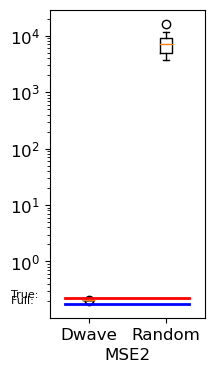

In [318]:
# Data 2 mse

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(mse_2.T.append(mse_r_2.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('MSE2')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_2[0], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_2[0]),f'Full:  ',fontsize=8)
plt.axhline(true_2[0], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_2[0]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)
plt.show()

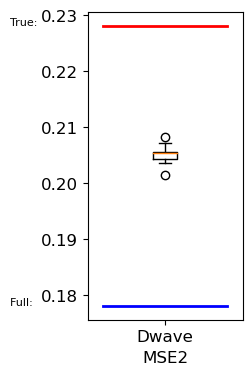

In [317]:
# Data 2 mse_without_random

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

#ax.boxplot(mse_2.T.append(mse_r_2.T).T)
ax.boxplot(mse_2)
#ax.boxplot(mse_r_1)
ax.set_xlabel('MSE2')
plt.xticks([1], ['Dwave'])
#plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_2[0], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_2[0]),f'Full:  ',fontsize=8)
plt.axhline(true_2[0], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_2[0]),f'True:  ',fontsize=8)
#plt.yscale('log', base=10)
plt.show()

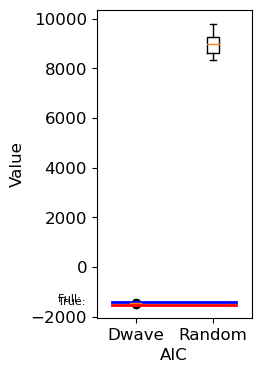

In [363]:
# Data 2  AIC

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(aic_2.T.append(aic_r_2.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('AIC')
ax.set_ylabel('Value')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_2[1], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_2[1]),f'Full:  ',fontsize=8)
plt.axhline(true_2[1], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_2[1]),f'True:  ',fontsize=8)
#plt.yscale('log', base=10)
plt.show()

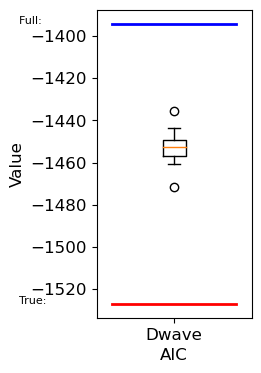

In [313]:
# Data 2  AIC

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

#ax.boxplot(aic_2.T.append(aic_r_2.T).T)
ax.boxplot(aic_2)
#ax.boxplot(mse_r_1)
ax.set_xlabel('AIC')
ax.set_ylabel('Value')
#plt.xticks([1,2], ['Dwave',"Random"])
plt.xticks([1], ['Dwave'])
plt.axhline(full_2[1], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_2[1]),f'Full:  ',fontsize=8)
plt.axhline(true_2[1], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_2[1]),f'True:  ',fontsize=8)
# plt.yscale('log', base=10)
plt.show()

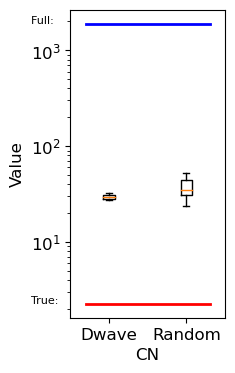

In [312]:
# Data 2  CN

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(cn_2.T.append(cn_r_2.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('CN')
ax.set_ylabel('Value')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_2[2], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_2[2]),f'Full:  ',fontsize=8)
plt.axhline(true_2[2], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_2[2]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)
plt.show()

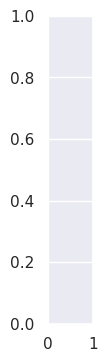

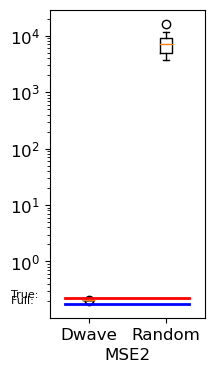

In [362]:
plt.subplot(131)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(mse_2.T.append(mse_r_2.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('MSE2')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_2[0], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_2[0]),f'Full:  ',fontsize=8)
plt.axhline(true_2[0], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_2[0]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)

In [ ]:
plt.subplot(131)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(mse_2.T.append(mse_r_2.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('MSE2')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_2[0], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_2[0]),f'Full:  ',fontsize=8)
plt.axhline(true_2[0], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_2[0]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)

plt.plot(~)
plt.subplot(132)
plt.plot(~)
plt.subplot(133)
plt.plot(~)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
C:\Users\user\AppData\Local\Temp/ipykernel_18440/3061209190.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_3 = pd.DataFrame(random_3).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/3061209190.py:14: DeprecationWarning: `np.flo

In [93]:
#### Data 3
x3,y3 = kqc_custom.generate_dependent_sample(1000,200,beta_coef=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],epsilon = 0.5)

In [94]:
# Real Variables
full_3 = full(x3,y3)
full_3

(array([[0.20187164]]), array([[-1269.2007574]]), 1843.7264593466841)

In [95]:
# True Variables
true_3 = full(pd.DataFrame(x3).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]],y3)
true_3

(array([[0.25229335]]), array([[-1406.2403153]]), 3.032930823915677)

In [96]:
# Random Variables

random_3=[]
for i in range(10):
    random_3.append(random(x3,y3))
random_3

[(array([[10062.66366117]]), array([[9377.50963327]]), 45.41915169670707),
 (array([[21193.27359399]]), array([[10082.36157422]]), 25.712740785121436),
 (array([[15768.71132106]]), array([[9800.70540671]]), 35.20737329661379),
 (array([[15913.69037963]]), array([[9793.85749511]]), 38.04262442503994),
 (array([[11405.23431221]]), array([[9474.75012641]]), 38.37201986948897),
 (array([[8430.64549587]]), array([[9188.55106655]]), 39.238938788816476),
 (array([[13986.95001916]]), array([[9672.8024796]]), 32.40836076771859),
 (array([[18666.33781346]]), array([[9961.39951097]]), 28.49203109939392),
 (array([[15738.61077335]]), array([[9782.79470438]]), 35.40738389893729),
 (array([[18025.50827947]]), array([[9924.46560755]]), 33.72536116079388)]

In [97]:
# Dwave Selected

dwave_3=[]
for i in range(10):
    dwave_3.append(dwave(x3,y3))

In [98]:
pd.DataFrame(dwave_3)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23126608176230004]],[[-1335.263915041517]],30.267879
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23111927129656873]],[[-1333.8989285413759]],35.049315
2,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[1121.131608452793]],[[7155.016266114455]],35.484520
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[1700.0724244856776]],[[7569.348578985653]],29.956180
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2309618515534605]],[[-1334.5802796782814]],33.203201
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.230707618032568]],[[-1335.6816457565685]],31.081484
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2269474902929292]],[[-1352.1141613446878]],31.944218
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[2680.8358701789866]],[[8024.806363944757]],27.934654
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.22662545620176658]],[[-1351.5341496740755]],36.966266
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2303807175402145]],[[-1335.0995976842366]],35.451214


In [ ]:
# 데이터 저장

data_x_3=pd.DataFrame(x3)
data_y_3=pd.DataFrame(y3)
data_x_3.to_excel('data_x3.xlsx')
data_y_3.to_excel('data_y3.xlsx')
pd.DataFrame(full_3).to_excel('data_x3_full.xlsx')
pd.DataFrame(true_3).to_excel('data_x3_true.xlsx')
pd.DataFrame(random_3).to_excel('data_x3_random.xlsx')
pd.DataFrame(dwave_3).to_excel('data_x3_dwave.xlsx')

# 그래프 만들기
mse_r_3 = pd.DataFrame(random_3).iloc[:,[0]].astype(np.float)
aic_r_3 = pd.DataFrame(random_3).iloc[:,[1]].astype(np.float)
cn_r_3 = pd.DataFrame(random_3).iloc[:,[2]].astype(np.float)
mse_3 = pd.DataFrame(dwave_3).iloc[:,[1]].astype(np.float)
aic_3 = pd.DataFrame(dwave_3).iloc[:,[2]].astype(np.float)
cn_3 = pd.DataFrame(dwave_3).iloc[:,[3]].astype(np.float)

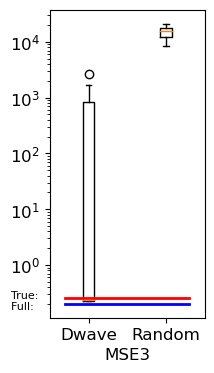

In [321]:
# Data 3 mse

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(mse_3.T.append(mse_r_3.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('MSE3')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_3[0], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_1[0]),f'Full:  ',fontsize=8)
plt.axhline(true_3[0], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_3[0]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)
plt.show()

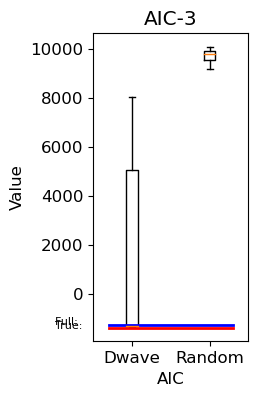

In [329]:
# Data 3  AIC

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(aic_3.T.append(aic_r_3.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('AIC')
ax.set_ylabel('Value')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_3[1], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_3[1]),f'Full:  ',fontsize=8)
plt.axhline(true_3[1], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_3[1]),f'True:  ',fontsize=8)
#plt.yscale('log', base=10)
plt.title("AIC-3")
plt.show()

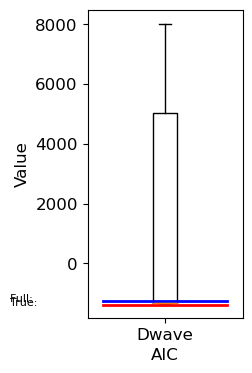

In [325]:
# Data 3  AIC _without random

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

#ax.boxplot(aic_3.T.append(aic_r_3.T).T)
ax.boxplot(aic_3)
#ax.boxplot(mse_r_1)
ax.set_xlabel('AIC')
ax.set_ylabel('Value')
plt.xticks([1], ['Dwave'])

plt.axhline(full_3[1], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_3[1]),f'Full:  ',fontsize=8)
plt.axhline(true_3[1], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_3[1]),f'True:  ',fontsize=8)
#plt.yscale('log', base=10)
plt.show()

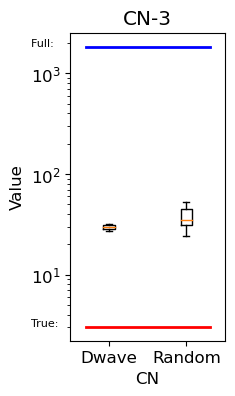

In [328]:
# Data 3  CN

plt.style.use('default')
plt.rcParams['figure.figsize'] = (2, 4)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(cn_2.T.append(cn_r_2.T).T)
#ax.boxplot(mse_r)
#ax.boxplot(mse_r_1)
ax.set_xlabel('CN')
ax.set_ylabel('Value')
plt.xticks([1,2], ['Dwave',"Random"])

plt.axhline(full_3[2], 0.1, 0.9, color='Blue', linestyle='-', linewidth=2)
ax.text(0,(full_3[2]),f'Full:  ',fontsize=8)
plt.axhline(true_3[2], 0.1, 0.9, color='Red', linestyle='-', linewidth=2)
ax.text(0,(true_3[2]),f'True:  ',fontsize=8)
plt.yscale('log', base=10)
plt.title("CN-3")
plt.show()

In [99]:
#### Data 4
x4,y4 = kqc_custom.generate_dependent_sample(1000,200,beta_coef=[10,10,9,9,8,8,7,7,6,6,5,5,4,4,3],epsilon = 1)

In [100]:
# Real Variables
full_4 = full(x4,y4)
full_4

(array([[0.79763379]]), array([[104.81674778]]), 1855.9786653210488)

In [101]:
# True Variables
true_4 = full(pd.DataFrame(x4).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]],y4)
true_4

(array([[0.96874249]]), array([[-68.83400417]]), 2.509807996677402)

In [102]:
# Random Variables

random_4=[]
for i in range(10):
    random_4.append(random(x4,y4))
random_4

[(array([[6459.16831445]]), array([[8878.17829181]]), 24.733007546059657),
 (array([[2936.28247017]]), array([[8137.8220415]]), 59.60851690779209),
 (array([[6637.63474295]]), array([[8931.43341281]]), 27.736255396570403),
 (array([[4694.28347133]]), array([[8577.02321194]]), 32.58781041470096),
 (array([[6486.31982816]]), array([[8916.3730434]]), 37.243675334334775),
 (array([[9735.2024621]]), array([[9310.42616214]]), 37.52228858684979),
 (array([[3345.7867805]]), array([[8236.37960303]]), 29.90470842452791),
 (array([[5110.81831136]]), array([[8696.0372568]]), 51.19953612923274),
 (array([[8531.66703016]]), array([[9180.46250004]]), 33.0426606689784),
 (array([[6864.4185197]]), array([[8947.02905967]]), 25.77478688231648)]

In [103]:
# Dwave Selected

dwave_4=[]
for i in range(10):
    dwave_4.append(dwave(x4,y4))

In [104]:
pd.DataFrame(dwave_4)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8921726655985665]],[[18.826853374385735]],30.539553
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8847130679681623]],[[8.430543681154063]],26.908480
2,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8963020084734729]],[[23.444587438420513]],32.149740
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[919.9361342590804]],[[6955.226695560026]],29.606773
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8810353396493307]],[[4.264906469054267]],29.931667
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8883191015602073]],[[12.498195273802764]],31.512136
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[429.39818922384546]],[[6195.307115654457]],29.652730
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8779702352660066]],[[2.779860680326692]],30.653609
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8832975966116711]],[[8.829341055774023]],30.896524
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.8840083115657705]],[[7.633633045206693]],28.893408


In [343]:
# 데이터 저장

data_x_4=pd.DataFrame(x4)
data_y_4=pd.DataFrame(y4)
data_x_4.to_excel('data_x4.xlsx')
data_y_4.to_excel('data_y4.xlsx')
pd.DataFrame(full_4).to_excel('data_x4_full.xlsx')
pd.DataFrame(true_4).to_excel('data_x4_true.xlsx')
pd.DataFrame(random_4).to_excel('data_x4_random.xlsx')
pd.DataFrame(dwave_4).to_excel('data_x4_dwave.xlsx')

# 그래프 만들기
mse_r_4 = pd.DataFrame(random_4).iloc[:,[0]].astype(np.float)
aic_r_4 = pd.DataFrame(random_4).iloc[:,[1]].astype(np.float)
cn_r_4 = pd.DataFrame(random_4).iloc[:,[2]].astype(np.float)
mse_4 = pd.DataFrame(dwave_4).iloc[:,[1]].astype(np.float)
aic_4 = pd.DataFrame(dwave_4).iloc[:,[2]].astype(np.float)
cn_4 = pd.DataFrame(dwave_4).iloc[:,[3]].astype(np.float)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
C:\Users\user\AppData\Local\Temp/ipykernel_18440/1722453260.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_4 = pd.DataFrame(random_4).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/1722453260.py:14: DeprecationWarning: `np.flo

In [105]:
#### Data 5
x5,y5 = kqc_custom.generate_dependent_sample(500,200,beta_coef=[5,5,5,5,5,5,5,5,5,5],epsilon = 0.5)

In [106]:
# Real Variables
full_5 = full(x5,y5)
full_5

(array([[0.16798996]]), array([[-554.07161157]]), 2930.59636629644)

In [107]:
# True Variables
true_5 = full(pd.DataFrame(x5).iloc[:,[0,1,2,3,4,5,6,7,8,9]],y5)
true_5

(array([[0.27086171]]), array([[-695.21951991]]), 2.419215634911562)

In [108]:
# Random Variables

random_5=[]
for i in range(10):
    random_5.append(random(x5,y5))
random_5

[(array([[835.54122784]]), array([[3519.89376498]]), 58.00223026008877),
 (array([[1337.28734433]]), array([[3743.05315463]]), 51.057432115373516),
 (array([[1641.34454641]]), array([[3835.48943417]]), 40.387723629081485),
 (array([[1698.84880924]]), array([[3874.70698383]]), 77.03261276828734),
 (array([[1237.96472783]]), array([[3712.46589981]]), 65.5453750498894),
 (array([[1655.83281066]]), array([[3827.88360407]]), 38.605991397547896),
 (array([[1060.22585674]]), array([[3628.97253742]]), 49.658216796181094),
 (array([[1732.46903299]]), array([[3884.50534738]]), 68.72424660645066),
 (array([[1309.92399102]]), array([[3730.71611521]]), 58.85211032953789),
 (array([[1165.36421775]]), array([[3666.24839421]]), 42.28365699820714)]

In [109]:
# Dwave Selected

dwave_5=[]
for i in range(10):
    dwave_5.append(dwave(x5,y5))
pd.DataFrame(dwave_5)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.21642569555226582]],[[-627.4000800140145]],37.277665
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.22978871185918656]],[[-597.4435991649781]],46.117848
2,"{'x000': 1.0, 'x001': 0.0, 'x002': 1.0, 'x003'...",[[295.57208289840116]],[[2982.3102902443484]],41.318959
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.22521709589166009]],[[-605.4913166525097]],37.485838
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.22618541082084279]],[[-605.34618808091]],40.114375
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.22037877572426595]],[[-616.3498336002864]],45.739696
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.21851451037745442]],[[-622.5975097848924]],42.824039
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.22307097636870915]],[[-612.2787202251924]],43.739230
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2192254349161605]],[[-618.9734287034107]],45.838130
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.21677562220518917]],[[-626.5923107051796]],39.352553


In [344]:
# 데이터 저장

data_x_5=pd.DataFrame(x5)
data_y_5=pd.DataFrame(y5)
data_x_5.to_excel('data_x5.xlsx')
data_y_5.to_excel('data_y5.xlsx')
pd.DataFrame(full_5).to_excel('data_x5_full.xlsx')
pd.DataFrame(true_5).to_excel('data_x5_true.xlsx')
pd.DataFrame(random_5).to_excel('data_x5_random.xlsx')
pd.DataFrame(dwave_5).to_excel('data_x5_dwave.xlsx')

# 그래프 만들기
mse_r_5 = pd.DataFrame(random_5).iloc[:,[0]].astype(np.float)
aic_r_5 = pd.DataFrame(random_5).iloc[:,[1]].astype(np.float)
cn_r_5 = pd.DataFrame(random_5).iloc[:,[2]].astype(np.float)
mse_5 = pd.DataFrame(dwave_5).iloc[:,[1]].astype(np.float)
aic_5 = pd.DataFrame(dwave_5).iloc[:,[2]].astype(np.float)
cn_5 = pd.DataFrame(dwave_5).iloc[:,[3]].astype(np.float)

C:\Users\user\AppData\Local\Temp/ipykernel_18440/1133994057.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_5 = pd.DataFrame(random_5).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/1133994057.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aic_r_5 = pd.DataFrame(random_5).iloc[:,[1]].astype(

In [110]:
#### Data 6
x6,y6 = kqc_custom.generate_dependent_sample(500,200,beta_coef=[5,5,5,5,5,5,5,5,5,5],epsilon = 0.01)

In [111]:
# Real Variables
full_6 = full(x6,y6)
full_6

(array([[6.0311234e-05]]), array([[-4520.14216551]]), 3102.7326339199226)

In [112]:
# True Variables
true_6 = full(pd.DataFrame(x6).iloc[:,[0,1,2,3,4,5,6,7,8,9]],y6)
true_6

(array([[9.49744981e-05]]), array([[-4673.09715296]]), 2.5913350623302454)

In [113]:
# Random Variables

random_6=[]
for i in range(10):
    random_6.append(random(x6,y6))
random_6

[(array([[1733.13352359]]), array([[3888.69708622]]), 65.66739684320473),
 (array([[1367.49403574]]), array([[3744.22150544]]), 41.32518546168134),
 (array([[2254.06209042]]), array([[3996.09853951]]), 48.22129363376776),
 (array([[2256.37902784]]), array([[3984.61222267]]), 42.41161051821162),
 (array([[1793.21905526]]), array([[3905.73773833]]), 62.34935430785524),
 (array([[528.50576023]]), array([[3280.88077125]]), 60.94260400946471),
 (array([[1973.73296831]]), array([[3929.69488723]]), 48.87516204261186),
 (array([[1935.62093438]]), array([[3917.94564417]]), 53.90227560613922),
 (array([[2723.56839442]]), array([[4074.70302362]]), 50.271976441864744),
 (array([[1464.79656958]]), array([[3788.58974474]]), 56.177527546589644)]

In [114]:
# Dwave Selected

dwave_6=[]
for i in range(10):
    dwave_6.append(dwave(x6,y6))
pd.DataFrame(dwave_6)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.91062130848963e-05]],[[-4586.505650513191]],42.465797
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.85661474041488e-05]],[[-4587.930903938412]],43.304270
2,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.837260518048784e-05]],[[-4589.164138678658]],45.224091
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.44164251120214e-05]],[[-4615.0630174122825]],41.793397
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.944677693765944e-05]],[[-4582.357697475737]],41.276093
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[341.2166911921774]],[[3052.1127857693405]],34.566445
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.794129002442141e-05]],[[-4591.923434326283]],38.061096
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.906980026920074e-05]],[[-4586.735854926405]],34.345195
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.637065217139183e-05]],[[-4604.102115720434]],38.200593
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[7.861483119689083e-05]],[[-4587.621173112632]],42.247475


In [345]:
# 데이터 저장

data_x_6=pd.DataFrame(x6)
data_y_6=pd.DataFrame(y6)
data_x_6.to_excel('data_x6.xlsx')
data_y_6.to_excel('data_y6.xlsx')
pd.DataFrame(full_6).to_excel('data_x6_full.xlsx')
pd.DataFrame(true_6).to_excel('data_x6_true.xlsx')
pd.DataFrame(random_6).to_excel('data_x6_random.xlsx')
pd.DataFrame(dwave_6).to_excel('data_x6_dwave.xlsx')

# 그래프 만들기
mse_r_6 = pd.DataFrame(random_6).iloc[:,[0]].astype(np.float)
aic_r_6 = pd.DataFrame(random_6).iloc[:,[1]].astype(np.float)
cn_r_6 = pd.DataFrame(random_6).iloc[:,[2]].astype(np.float)
mse_6 = pd.DataFrame(dwave_6).iloc[:,[1]].astype(np.float)
aic_6 = pd.DataFrame(dwave_6).iloc[:,[2]].astype(np.float)
cn_6 = pd.DataFrame(dwave_6).iloc[:,[3]].astype(np.float)

C:\Users\user\AppData\Local\Temp/ipykernel_18440/734480221.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_6 = pd.DataFrame(random_6).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/734480221.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aic_r_6 = pd.DataFrame(random_6).iloc[:,[1]].astype(np

In [115]:
#### Data 6
x7,y7 = kqc_custom.generate_dependent_sample(2000,200,beta_coef=[15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15],epsilon = 0.5)

In [116]:
# Real Variables
full_7 = full(x7,y7)
full_7

(array([[0.21587329]]), array([[-2742.13633993]]), 1567.083975922726)

In [117]:
# True Variables
true_7 = full(pd.DataFrame(x7).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]],y7)
true_7

(array([[0.24120782]]), array([[-2880.20185173]]), 2.7641246962783432)

In [118]:
# Random Variables

random_7=[]
for i in range(10):
    random_7.append(random(x7,y7))
random_7

[(array([[32344.87031493]]), array([[20892.41241348]]), 38.33762883563206),
 (array([[45608.9662254]]), array([[21567.71018325]]), 26.521613444837307),
 (array([[34040.61777895]]), array([[20994.61043769]]), 33.67910935637043),
 (array([[32338.29138141]]), array([[20882.00557291]]), 27.791041481469012),
 (array([[35231.02341262]]), array([[21077.35561616]]), 38.370834378819595),
 (array([[38563.91014134]]), array([[21256.13527073]]), 39.73959780084341),
 (array([[23359.82977724]]), array([[20261.53727537]]), 42.67769205367565),
 (array([[33173.63607733]]), array([[20935.01246618]]), 31.797706835545714),
 (array([[48209.98032225]]), array([[21672.63365387]]), 26.2655625069337),
 (array([[38833.2023062]]), array([[21256.05275385]]), 36.81306352375036)]

In [119]:
# Dwave Selected

dwave_7=[]
for i in range(10):
    dwave_7.append(dwave(x7,y7))
pd.DataFrame(dwave_7)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2309390094999203]],[[-2807.2122875169853]],25.910693
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23135397756578413]],[[-2803.6217664498163]],26.761127
2,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23208526387109146]],[[-2793.3099408910266]],26.564230
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.22889007631360686]],[[-2825.0358381360047]],22.955378
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[2651.011652009653]],[[15889.384178615634]],28.583679
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2331048627950711]],[[-2786.5427680880316]],28.047937
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[3089.55931975204]],[[16195.558464913245]],27.434757
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.232518977749231]],[[-2791.575889711356]],22.874116
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23038470384346557]],[[-2812.018508460576]],30.541865
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2306001583183754]],[[-2810.148993790722]],29.534613


In [346]:
# 데이터 저장

data_x_7=pd.DataFrame(x7)
data_y_7=pd.DataFrame(y7)
data_x_7.to_excel('data_x7.xlsx')
data_y_7.to_excel('data_y7.xlsx')
pd.DataFrame(full_7).to_excel('data_x7_full.xlsx')
pd.DataFrame(true_7).to_excel('data_x7_true.xlsx')
pd.DataFrame(random_7).to_excel('data_x7_random.xlsx')
pd.DataFrame(dwave_7).to_excel('data_x7_dwave.xlsx')

# 그래프 만들기
mse_r_7 = pd.DataFrame(random_7).iloc[:,[0]].astype(np.float)
aic_r_7 = pd.DataFrame(random_7).iloc[:,[1]].astype(np.float)
cn_r_7 = pd.DataFrame(random_7).iloc[:,[2]].astype(np.float)
mse_7 = pd.DataFrame(dwave_7).iloc[:,[1]].astype(np.float)
aic_7 = pd.DataFrame(dwave_7).iloc[:,[2]].astype(np.float)
cn_7 = pd.DataFrame(dwave_7).iloc[:,[3]].astype(np.float)

C:\Users\user\AppData\Local\Temp/ipykernel_18440/3680811283.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_7 = pd.DataFrame(random_7).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/3680811283.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aic_r_7 = pd.DataFrame(random_7).iloc[:,[1]].astype(

In [120]:
#### Data 6
x8,y8 = kqc_custom.generate_dependent_sample(2000,200,beta_coef=[15,15,15,15,15,15,15,15,15,15,15,15,15,15,15],epsilon = 0.5)
full_8 = full(x8,y8)
true_8 = full(pd.DataFrame(x8).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]],y8)
random_8=[]
for i in range(10):
    random_8.append(random(x8,y8))
dwave_8=[]
for i in range(10):
    dwave_8.append(dwave(x8,y8))

In [123]:
full_8

(array([[0.22652843]]), array([[-2645.77869109]]), 1623.031981041242)

In [124]:
true_8

(array([[0.25036116]]), array([[-2815.71055143]]), 2.6390693384497443)

In [125]:
random_8

[(array([[36403.44018428]]), array([[21124.82809484]]), 27.98994248461404),
 (array([[24415.40381301]]), array([[20323.93000721]]), 31.630166704164893),
 (array([[25817.39396839]]), array([[20415.59843255]]), 25.5110047631362),
 (array([[28680.80413154]]), array([[20645.95764016]]), 28.87261870243803),
 (array([[35795.7166108]]), array([[21101.15801038]]), 33.815712630468234),
 (array([[30839.56669008]]), array([[20793.09853005]]), 36.44627669201378),
 (array([[27033.23915625]]), array([[20529.63591078]]), 36.01632360012535),
 (array([[34082.21100128]]), array([[21005.05268668]]), 35.47653629084038),
 (array([[41444.02521042]]), array([[21376.18898675]]), 31.97665774380928),
 (array([[16708.69204687]]), array([[19601.3596651]]), 45.692464346051004)]

In [126]:
pd.DataFrame(dwave_8)

,0,1,2,3
0,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2377956402308241]],[[-2748.696281911276]],24.076477
1,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23765902188453675]],[[-2747.8456520694276]],27.109627
2,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23679989892038203]],[[-2755.0886302531653]],25.525328
3,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[3629.4884093920978]],[[16519.68494195457]],24.574142
4,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23755324780229875]],[[-2750.735983323328]],22.743500
5,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[3965.607665524795]],[[16696.819734823657]],27.236756
6,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2392645377805029]],[[-2734.3799976399905]],27.838275
7,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23815727129389416]],[[-2745.6570641743638]],28.630437
8,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.23682672766841825]],[[-2754.862048836]],25.132007
9,"{'x000': 1.0, 'x001': 1.0, 'x002': 1.0, 'x003'...",[[0.2381278887455801]],[[-2745.90382851486]],25.268500


In [347]:
# 데이터 저장

data_x_8=pd.DataFrame(x8)
data_y_8=pd.DataFrame(y8)
data_x_8.to_excel('data_x8.xlsx')
data_y_8.to_excel('data_y8.xlsx')
pd.DataFrame(full_8).to_excel('data_x8_full.xlsx')
pd.DataFrame(true_8).to_excel('data_x8_true.xlsx')
pd.DataFrame(random_8).to_excel('data_x8_random.xlsx')
pd.DataFrame(dwave_8).to_excel('data_x8_dwave.xlsx')

# 그래프 만들기
mse_r_8 = pd.DataFrame(random_8).iloc[:,[0]].astype(np.float)
aic_r_8 = pd.DataFrame(random_8).iloc[:,[1]].astype(np.float)
cn_r_8 = pd.DataFrame(random_8).iloc[:,[2]].astype(np.float)
mse_8 = pd.DataFrame(dwave_8).iloc[:,[1]].astype(np.float)
aic_8 = pd.DataFrame(dwave_8).iloc[:,[2]].astype(np.float)
cn_8 = pd.DataFrame(dwave_8).iloc[:,[3]].astype(np.float)

C:\Users\user\AppData\Local\Temp/ipykernel_18440/1075155408.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mse_r_8 = pd.DataFrame(random_8).iloc[:,[0]].astype(np.float)
C:\Users\user\AppData\Local\Temp/ipykernel_18440/1075155408.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aic_r_8 = pd.DataFrame(random_8).iloc[:,[1]].astype(

In [121]:
#### Data 9
x9,y9 = kqc_custom.generate_dependent_sample(1000,200,beta_coef=[10,10,10,10,10,10,10,10,10,10],epsilon = 1)
full_9 = full(x9,y9)
true_9 = full(pd.DataFrame(x9).iloc[:,[0,1,2,3,4,5,6,7,8,9]],y9)
random_9=[]
for i in range(10):
    random_9.append(random(x9,y9))
dwave_9=[]
for i in range(10):
    dwave_9.append(dwave(x9,y9))

SolverFailureError: Problem not accepted because user rabbitshell@yonsei.ac.kr has insufficient remaining solver access time in project DEV

In [ ]:
#### Data 10
x10,y10 = kqc_custom.generate_dependent_sample(1000,200,beta_coef=[10,10,10,10,10,10,10,10,10,10],epsilon = 2)
full_10 = full(x10,y10)
true_10 = full(pd.DataFrame(x10).iloc[:,[0,1,2,3,4,5,6,7,8,9]],y10)
random_10=[]
for i in range(10):
    random_10.append(random(x10,y10))
dwave_10=[]
for i in range(10):
    dwave_10.append(dwave(x10,y10))

In [ ]:
#### Data 11
x11,y11 = kqc_custom.generate_dependent_sample(1000,200,beta_coef=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],epsilon = 0.5)
full_11 = full(x11,y11)
true_11 = full(pd.DataFrame(x11).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]],y11)
random_11=[]
for i in range(10):
    random_11.append(random(x11,y11))
dwave_11=[]
for i in range(10):
    dwave_11.append(dwave(x11,y11))

In [ ]:
#### Data 12
x12,y12 = kqc_custom.generate_dependent_sample(1500,200,beta_coef=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],epsilon = 0.5)
full_12 = full(x12,y12)
true_12 = full(pd.DataFrame(x12).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]],y12)
random_12=[]
for i in range(10):
    random_12.append(random(x12,y12))
dwave_12=[]
for i in range(10):
    dwave_12.append(dwave(x12,y12))

In [ ]:
#### Data 13
x13,y13 = kqc_custom.generate_dependent_sample(500,200,beta_coef=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10],epsilon = 0.5)
full_13 = full(x13,y13)
true_13 = full(pd.DataFrame(x13).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]],y13)
random_13=[]
for i in range(10):
    random_12.append(random(x13,y13))
dwave_13=[]
for i in range(10):
    dwave_13.append(dwave(x13,y13))